# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
# !wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2024-11-09 00:09:54--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2024-11-09 00:09:54--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M  --.-KB/s    in 0.1s    

2024-11-09 00:09:57 (284 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    try:
      tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    except:
      return 'no such file'
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
      # you need: xmin ymin xmax ymax, class in dict
      class_str = member.find('name').text
      try:
        class_int = class_dict[class_str]
      except:
        raise Exception(f'{class_str} not in dictionary')
      for bndbox in member.findall('bndbox'):
        res = []
        for param in ['xmin', 'ymin', 'xmax', 'ymax']:
          res.append(int(bndbox.find(param).text))
        res.append(class_int)
        bboxes.append(res)

    return bboxes

In [29]:
# ПРОВЕРЯЕМ, ЧТО ФУНКЦИЯ РАБОТАЕТ

root = '/content/data'

with open(root + "/class_dict", "r") as f:
  class_dict = eval(f.readline())

for n in range(2383, 2704):
  image_name = 'IMG_'+str(n)
  print(f'{image_name}: {get_xml_data(image_name, root, class_dict)}')

print(class_dict)

IMG_2383: [[97, 136, 275, 368, 2]]
IMG_2384: [[135, 203, 229, 327, 0]]
IMG_2385: [[92, 183, 223, 348, 0]]
IMG_2386: [[109, 165, 251, 344, 2]]
IMG_2387: [[109, 167, 249, 349, 5]]
IMG_2388: [[69, 220, 228, 406, 0]]
IMG_2389: [[118, 205, 246, 384, 2]]
IMG_2390: [[106, 191, 243, 382, 2]]
IMG_2391: [[129, 197, 268, 389, 4]]
IMG_2392: [[129, 167, 242, 330, 4]]
IMG_2393: [[108, 143, 278, 377, 4]]
IMG_2394: [[134, 233, 228, 352, 4]]
IMG_2395: [[81, 192, 229, 388, 3]]
IMG_2396: [[126, 172, 254, 350, 4]]
IMG_2397: [[123, 191, 266, 384, 3]]
IMG_2398: [[114, 184, 264, 375, 1]]
IMG_2399: [[111, 170, 252, 364, 5]]
IMG_2400: [[92, 141, 244, 348, 5]]
IMG_2401: [[105, 208, 249, 398, 5]]
IMG_2402: [[130, 205, 252, 371, 5]]
IMG_2403: [[87, 116, 286, 388, 1]]
IMG_2404: [[121, 228, 215, 360, 1]]
IMG_2405: [[82, 276, 175, 401, 1]]
IMG_2406: [[189, 207, 311, 367, 3]]
IMG_2407: [[128, 196, 243, 357, 1]]
IMG_2408: [[137, 224, 275, 411, 1]]
IMG_2409: [[74, 295, 169, 429, 3]]
IMG_2410: [[104, 195, 237, 372, 3]]


In [5]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = np.asarray(Image.open(fname))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [6]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# mean = (0.5, 0.5, 0.5)
# std = (0.5, 0.5, 0.5)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

resize_transform = A.Compose(
    [
        A.Resize(512, 512),
    ]
)


In [7]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [8]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    ncols = 2
    nrows = len(images) // 2 + len(images) % 2

    fig, axes = plt.subplots(
        ncols, nrows, figsize=(10, 8), dpi=100
    )


    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        image = images[i]
        image = image.numpy()

        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        image = image.transpose([1, 2, 0])

        # И откатить нормализацию (просто обратное преобразование)
        image = image * std + mean


        ax.imshow(image)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        # ax.imshow(### YOUR CODE HERE ###)

        for bbox in bboxes[i]:
          class_int = int(bbox[-1])
          class_str = train_ds.class_dict_inv[class_int]

          xmin, ymin, xmax, ymax, _ = bbox

          ax.add_patch(Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), alpha=0.5))
          ax.text(xmin, ymin, class_str)

    fig.tight_layout()
    plt.show()



У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

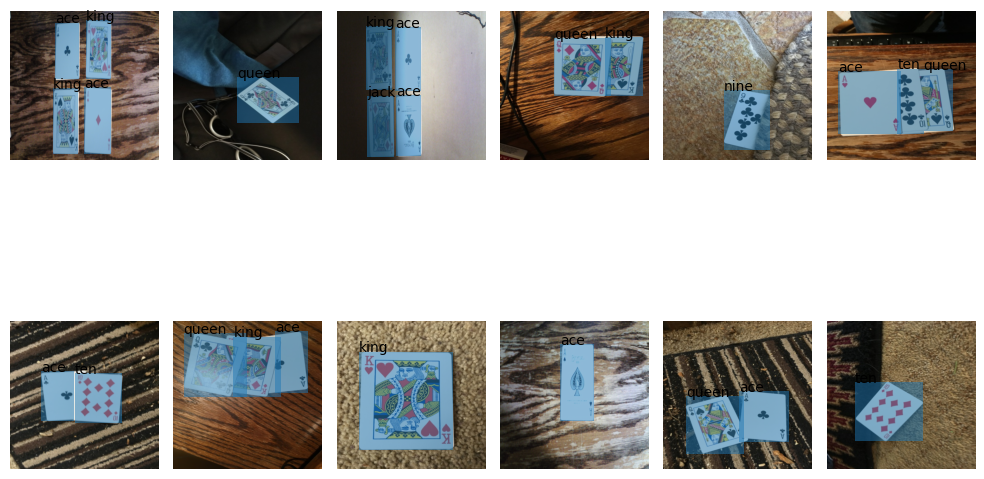

In [9]:
out = [train_ds[i] for i in range(12)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [30]:
def collate_fn(batch, downsample=32, log=False):

    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))
    imgs = torch.stack(imgs)

    b, _, h, w = imgs.shape

    if log:
      print(f'{h = }, {w = }')

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        if log:
          print(f'{xmin = }, {xmax = }, {ymin = }, {ymax = }')
        original_width = (xmax - xmin) / w
        original_height = (ymax - ymin) / h

        if log:
          print(f'{original_width = }, {original_height = }')
        # Нормализуйте ширину и высоту, поделив на ширину и высоту
        # исходного изображения
        x_cell =  downsample
        y_cell =  downsample
        w_box =  original_width / downsample
        h_box =  original_height / downsample

        if log:
          print(f'{x_cell = }, {y_cell = }')
          print(f'{w_box = }, {h_box = }')

        # Посчитайте координаты центра и сдвиги

        # (координаты центра в исходных координатах)
        cx =  xmin + (original_width / 2)
        cy =  ymin + (original_height / 2)


        if log:
          print(f'{cx = }, {cy = }')

        # (посчитайте индекс центра на карте признаков размера 16x16.
        # Это будут как раз координаты пикселя, куда мы запишем параметры
        # коробки)

        cx_idx = (cx // downsample).int()
        cy_idx =  (cy // downsample).int()

        if log:
          print(f'{cx_idx = }, {cy_idx = }')


        cx_box = (cx % x_cell) / x_cell
        cy_box = (cy % y_cell) / y_cell

        if log:
          print(f'{cx_box = }, {cy_box = }')

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    return {"image": imgs.to(device), "target": target.to(device)}


# Для проверки:
batch = []
batch.append(train_ds[4])
batch.append(train_ds[5])
z = collate_fn(batch)


# visualize([batch[0]['image']], [batch[0]['bboxes']])


z['target'][0][0][7][4]
z

{'image': tensor([[[[-0.3027, -0.0801,  0.1939,  ...,  1.4612,  1.3242,  1.2043],
           [-0.0116,  0.0569,  0.1939,  ...,  1.4612,  1.2557,  1.0673],
           [-0.1143, -0.0629,  0.0056,  ...,  1.0502,  0.9474,  0.8276],
           ...,
           [-0.7993, -0.8507, -0.8678,  ..., -0.0801, -0.0287, -0.0116],
           [-0.7308, -0.7308, -0.6965,  ...,  0.0227,  0.0227,  0.0741],
           [-0.6109, -0.5938, -0.5938,  ..., -0.0116,  0.0398,  0.0741]],
 
          [[-0.4076, -0.1625,  0.1352,  ...,  1.5882,  1.4482,  1.3256],
           [-0.1099, -0.0049,  0.1702,  ...,  1.5882,  1.3782,  1.1856],
           [-0.1800, -0.1099, -0.0224,  ...,  1.1331,  1.0280,  0.8880],
           ...,
           [-0.9153, -0.9678, -1.0028,  ..., -0.1450, -0.0749, -0.0224],
           [-0.8452, -0.8452, -0.8102,  ..., -0.0399, -0.0399,  0.0126],
           [-0.7227, -0.7052, -0.7052,  ..., -0.0924, -0.0224,  0.0126]],
 
          [[-0.3404, -0.0964,  0.1999,  ...,  1.8383,  1.6814,  1.5594],
    

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

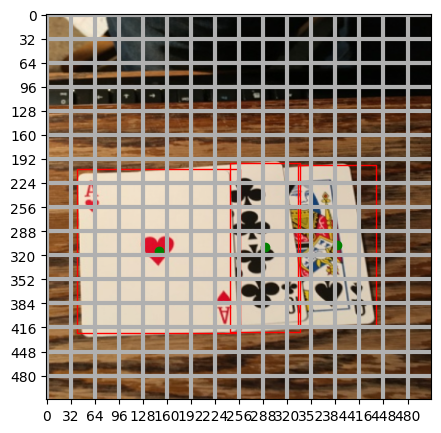

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 5

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [10]:
# пока предположим, что на вход приходят списки списков ббоксов с
# предсказаниями
# [[[ббокс 1 изобр 1], [ббокс 2 изобр 1]],
#  [[ббокс 1 изобр 2]]]


def decode_prediction(pred, upsample=32, threshold=0.7, log=False):
    n_imgs, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample

    it_is_prediction = False

    if c > 6:
      it_is_prediction = True


    all_img_bboxes = []
    for img in range(n_imgs):
      current_img_bboxes = pred[img]
      if log:
        print(f'{len(current_img_bboxes) = }')
      x_shifts = current_img_bboxes[0]
      y_shifts = current_img_bboxes[1]
      norm_widths = current_img_bboxes[2]
      norm_heights = current_img_bboxes[3]
      confidences = current_img_bboxes[4]
      classes = current_img_bboxes[5]
      if it_is_prediction:
        classes = current_img_bboxes[5:]

      # достаём координаты idx и idy для всех отличных от нуля в первом же 15Х15
      # дальше проходимся и всё получаем

      bboxes = []
      all_bbox_coords = torch.nonzero(confidences > threshold)
      if log:
        print(f'{all_bbox_coords = }')
      for y, x in all_bbox_coords:
        if log:
          print(f'{x = }, {y = }')
        x_shift = x_shifts[y][x]
        y_shift = y_shifts[y][x]
        norm_width = norm_widths[y][x]
        norm_height = norm_heights[y][x]
        confidence = confidences[y][x]
        if it_is_prediction:
          int_class = classes[:, y, x]
        else:
          int_class = classes[y][x]

        if log:
          print(f'{x_shift = }, {y_shift = },\n{norm_width = }, {norm_width = },\n{confidence = }, {int_class = }')

        cx = x * upsample + x_shift * upsample
        cy = y * upsample + y_shift * upsample
        if log:
          print(f'{cx = }, {cy = }')
        w = norm_width * upsample
        h = norm_height * upsample

        xmin = cx - (w / 2)
        ymin = cy - (h / 2)
        xmax = cx + (w / 2)
        ymax = cy + (h / 2)

        if not it_is_prediction:
          pred_class = int_class

        if it_is_prediction:
          # print(f'{int_class = }')
          pred_class = torch.argmax(int_class)

        bboxes.append([xmin.item(), ymin.item(), xmax.item(),
                       ymax.item(), pred_class.item()])

      all_img_bboxes.append(bboxes)

    return all_img_bboxes


# проверка

batch = []
batch.append(train_ds[3])
batch.append(train_ds[4])
batch.append(train_ds[5])

coded = collate_fn(batch)['target']

decoded = decode_prediction(coded)

for img in batch:
  print(img['bboxes'])

print()

for img in decoded:
  print(img)



# pred[0][4]

[[186.92063903808594, 92.44444274902344, 381.96826171875, 292.5714416503906, 5.0], [363.0052795410156, 87.36508178710938, 493.03704833984375, 290.5396728515625, 0.0]]
[[209.94708251953125, 271.23809814453125, 367.06878662109375, 478.4761962890625, 4.0]]
[[334.56085205078125, 200.12698364257812, 437.5026550292969, 413.4603271484375, 5.0], [243.8095245361328, 197.07936096191406, 337.26983642578125, 421.5873107910156, 3.0], [40.63492202758789, 205.2063446044922, 257.3544921875, 423.6190490722656, 2.0]]

[[186.92063903808594, 92.44444274902344, 187.3015899658203, 92.83531188964844, 5.0], [363.0052795410156, 87.36508178710938, 363.2592468261719, 87.76190185546875, 0.0]]
[[209.94708251953125, 271.23809814453125, 210.25396728515625, 271.64288330078125, 4.0]]
[[40.63492202758789, 205.2063446044922, 41.05820083618164, 205.63291931152344, 2.0], [243.8095245361328, 197.07936096191406, 243.99205017089844, 197.5178680419922, 3.0], [334.56085205078125, 200.12698364257812, 334.76190185546875, 200.543

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [ ]:
C = len(train_ds.class_dict)
print(f'{C = }')

# Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

        self.first_part = nn.Sequential(*list(resnet.children())[0:8])

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=2048, out_channels=512, kernel_size=3, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=128, kernel_size=3, padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=32, kernel_size=3, padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(
                in_channels=32, out_channels=5+C, kernel_size=3, padding=1
            ),
            nn.BatchNorm2d(5+C),
            nn.ReLU()
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, imgs):
        pred = self.first_part(imgs)
        pred = self.conv_block1(pred)
        pred = self.conv_block2(pred)
        pred = self.conv_block3(pred)
        pred = self.conv_block4(pred)

        return self.sigmoid(pred)


loader = torch.utils.data.DataLoader(train_ds, 1, collate_fn=collate_fn)
for batch in loader:
  b = batch
  break

mdl = Detector()
mdl.to(device)
imgs = b['image'].to(device)

pred = mdl(imgs)

pred.size()
# print(pred.size())

# z = pred[0][0:6].unsqueeze(0)
# decode_prediction(z)



C = 6


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


torch.Size([1, 11, 16, 16])

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
def select_mask_param(tensor, id, mask):
  return torch.masked_select(tensor[:, id, :, :], mask)



def get_classification_loss(tensor, target_conf_class):
  n_images, n_classes, _, _ = tensor.size()

  loss = nn.CrossEntropyLoss(reduction='sum')

  for n in range(n_images):
    mask_for_img = target_conf_class[n, 0, :, :] == 1
    img_target_classes = torch.masked_select(target_conf_class[n, 1, :, :], mask_for_img).long()
    n_answers = img_target_classes.size()[0]

    mask_for_img = torch.unsqueeze(mask_for_img, 0)
    mask_for_img = mask_for_img.repeat(n_classes, 1, 1)

    img_class_pred = torch.masked_select(tensor[n, :, :, :], mask_for_img).reshape(n_classes, n_answers)
    img_class_pred = torch.transpose(img_class_pred, 0, 1)

    img_loss = loss(img_class_pred, img_target_classes)

    # print(f'{img_loss = }')
    if n == 0:
      losses = img_loss
    else:
      # print(f'{losses.squeeze() = }')
      losses = losses.squeeze()
      losses = torch.cat((losses.reshape(n), img_loss.reshape(1)), 0)
    # print(f'{losses = }')
    # print(f'{n = }')

  losses = losses.sum()

  return losses




def get_confidence_loss(tensor_conf, target_conf):
  n_images, _, _, = tensor_conf.size()
  # print(f'{n_images = }')
  # print(f'{tensor_conf.size() = }')
  # print(f'{target_conf.size() = }')

  loss = nn.BCELoss(reduction='sum')

  for n in range(n_images):
    pred_conf = tensor_conf[n]
    targ_conf = target_conf[n]
    img_loss = loss(pred_conf, targ_conf)

    # print(f'{img_loss = }')

    if n == 0:
      losses = img_loss
    else:
      # print(f'{losses.squeeze() = }')
      losses = losses.squeeze()
      losses = torch.cat((losses.reshape(n), img_loss.reshape(1)), 0)

  losses = losses.sum()
  return losses



def special_loss(pred, target, check=False, C=C):
    ### YOUR CODE HERE ###

    id = ['x_shift', 'y_shift', 'w_box', 'h_box', 'confidence', 'class']
    id = {k:v for v, k in enumerate(id)}

    mask = target[:, id['confidence'], :, :] == 1

    # LOCALIZATION LOSS

    target_x = select_mask_param(target, id['x_shift'], mask)
    pred_x = select_mask_param(pred, id['x_shift'], mask)
    target_y = select_mask_param(target, id['y_shift'], mask)
    pred_y = select_mask_param(pred, id['y_shift'], mask)

    localization_loss = (nn.MSELoss(reduction='sum')(target_x, pred_x) + \
                         nn.MSELoss(reduction='sum')(target_y, pred_y))

    # BOX LOSS

    target_w = torch.sqrt(select_mask_param(target, id['w_box'], mask))
    pred_w = torch.sqrt(select_mask_param(pred, id['w_box'], mask))
    target_h = torch.sqrt(select_mask_param(target, id['h_box'], mask))
    pred_h = torch.sqrt(select_mask_param(pred, id['h_box'], mask))

    localization_loss = (nn.MSELoss(reduction='sum')(target_x, pred_x) + \
                         nn.MSELoss(reduction='sum')(target_y, pred_y))

    box_loss = (nn.MSELoss(reduction='sum')(target_w, pred_w) + \
                         nn.MSELoss(reduction='sum')(target_h, pred_h))

    # CLASSIFICATION LOSS
    classification_loss = get_classification_loss(pred[:, id['class']:, :, :],
                                                  target[:, id['confidence']:, :, :])

    # CONFIDENCE LOSS
    confidence_loss = get_confidence_loss(pred[:, id['confidence'], :, :],
                                          target[:, id['confidence'], :, :])

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 6, 16, 16)), check=True, C=3) == \
    (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# dummy_pred = torch.zeros((2, 5+C, 16, 16))
# dummy_pred[0][8][5][3] = 4
# dummy_pred[1][8][6][8] = 4
# dummy_pred[1][6][11][6] = 2
# dummy_pred[1][5][8][2] = 1
# dummy_pred[1][5][10][12] = 1

# special_loss(dummy_pred, collate_fn([train_ds[0], train_ds[1]])['target'], check=True, C=C)

# если будет ошибка, что на BCELoss что-то не между 0 и 1, надо будет
# пропускать через сигмоиду (в примере BCELoss приведён пример)

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить


# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [13]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 2 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=0.0001) # 1e-3



for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
      pred = model(batch['image'])
      target = batch['target']
      loss = special_loss(pred, target)
      epoch_losses.append(loss.clone().detach().cpu())
      pbar.set_description(f'avg loss so far: {np.mean(epoch_losses):.3f}')
      loss.backward()
      opt.step()
      opt.zero_grad()


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 2045.601;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 1864.624;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu

pred = model(batch['image']).clone().detach().cpu()

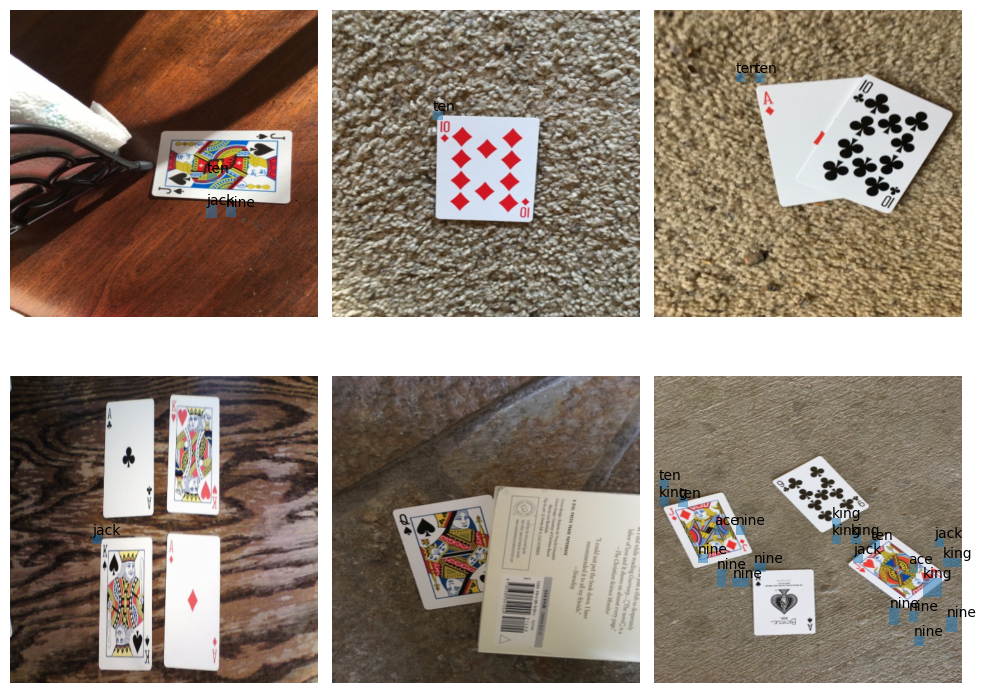

In [ ]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1


decoded = decode_prediction(pred, threshold=0.6)

visualize(images=batch['image'].clone().detach().cpu(), bboxes = decoded)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [11]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 55.5 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [12]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [39]:
def annotation2txt(bboxes, w_im, h_im):
    one_liners = []
    for bbox in bboxes:
      # print(f'{w_im = }, {h_im = }')
      xmin, ymin, xmax, ymax, class_id = bbox
      width = (xmax - xmin) / w_im
      height = (ymax - ymin) / h_im
      center_x = (xmin + (xmax - xmin) / 2) / w_im
      center_y = (ymin + (ymax - ymin) / 2) / h_im
      one_liner = [str(x) for x in [class_id, center_x, center_y, width, height]]
      one_liner = ' '.join(one_liner)
      one_liners.append(one_liner)

    return one_liners

# ВХОД:
# bboxes:
# 'xmin', 'ymin', 'xmax', 'ymax', 'class'
# [['90', '17', '203', '104', 4],
#  ['48', '272', '92', '391', 4],
#  ['269', '187', '372', '311', 1],
#  ['171', '382', '265', '477', 2]]
# w_im, h_im -- ширина и высота изображения
# 504     378    например

# ВЫХОД
# нужный формат -- строка:
# class_id center_x center_y width height
# 1 0.617 0.3594420600858369 0.114 0.17381974248927037
# where fields are space delimited, and the coordinates are normalized from zero to one
# координаты, получается, делим на общую ширину / высоту для нормализации


# ПРОВЕРКА
result = train_ds.__get_raw_item__(4)

h_im, w_im, ch = np.array(Image.open(result[0])).shape

annotation2txt(result[1], w_im, h_im), result[1], h_im, w_im, result[0]

(['4 0.5634920634920635 0.7321428571428571 0.30687830687830686 0.40476190476190477'],
 [[155, 267, 271, 471, 4]],
 504,
 378,
 './data//images/IMG_2544.JPG')

In [40]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)
    # print(result[0])

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)
    # print(result[0])

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    # h_im, w_im, ch = np.array(Image.open(result[0])).shape

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [41]:
# Собираем YAML

nc = len(train_ds.class_dict) # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = list(train_ds.class_dict.keys()) # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

# print(names)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
import ultralytics

model = ultralytics.YOLO('yolov8n.yaml')

results = model.train(data="data.yaml", epochs=100)

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

train: Scanning /content/train/labels.cache... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 37 images, 0 backgrounds, 4 corrupt: 100%|██████████| 37/37 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/valid/images/cam_image19.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2368]
val: WARNING ⚠️ /content/valid/images/cam_image4.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5106      1.5291]
val: WARNING ⚠️ /content/valid/images/cam_image54.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1468      1.1005      1.5648]
val: WARNING ⚠️ /content/valid/images/cam_image7.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4272      1.4233]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.51G      2.971       4.64      4.396         38        640: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         33         57    0.00161      0.125    0.00152   0.000238


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [138]:

model_best = ultralytics.YOLO('yolov8n.yaml').load('./runs/detect/train5/weights/best.pt')


from os import listdir
from os.path import isfile, join

mypath = '/content/train/images/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

onlyfiles = [f for f in onlyfiles if '.JPG' in f]


for file in onlyfiles:
  # print(file)
  filename = mypath + file
  pred = model.predict(source=filename)
  # pred = model_best.predict(source=filename)




Transferred 319/355 items from pretrained weights

image 1/1 /content/train/images/IMG_2590.JPG: 640x480 1 king, 1 jack, 1 ten, 2 nines, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/train/images/IMG_2698.JPG: 640x480 1 nine, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/train/images/IMG_2619.JPG: 640x480 1 jack, 1 ten, 1 nine, 21.9ms
Speed: 1.8ms preprocess, 21.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/train/images/IMG_2692.JPG: 640x480 1 king, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/train/images/IMG_2567.JPG: 640x480 2 jacks, 1 ace, 1 ten, 1 nine, 12.4ms
Speed: 2.7ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/train/images/IMG_2571.JPG: 640x480 1 

IMG_2461.JPG

image 1/1 /content/valid/images/IMG_2461.JPG: 640x480 1 ten, 1 nine, 25.1ms
Speed: 5.7ms preprocess, 25.1ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 480)
IMG_2410.JPG

image 1/1 /content/valid/images/IMG_2410.JPG: 640x480 1 ten, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 480)
IMG_2699.JPG

image 1/1 /content/valid/images/IMG_2699.JPG: 640x480 1 ace, 15.0ms
Speed: 4.0ms preprocess, 15.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)
IMG_2592.JPG

image 1/1 /content/valid/images/IMG_2592.JPG: 640x480 1 king, 1 jack, 1 ace, 1 ten, 16.7ms
Speed: 3.0ms preprocess, 16.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)
IMG_2618.JPG

image 1/1 /content/valid/images/IMG_2618.JPG: 640x480 1 nine, 13.6ms
Speed: 4.8ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)
IMG_2594.JPG

image 1/1 /content/valid/images/IMG_2594.JPG: 640x480 3 jac

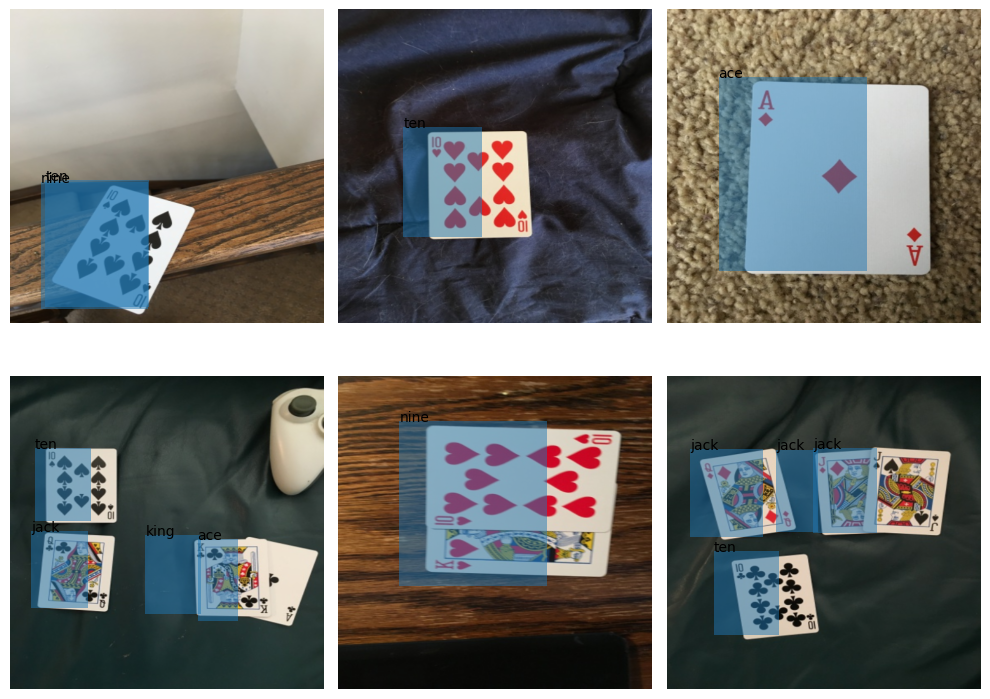

In [140]:
images_names = {}
n = 6
for i in range(n):
  filename, _ = test_ds.__get_raw_item__(i)
  name = filename[-12:]
  if 'IMG' not in name:
    continue
  images_names[i] = name

images = {}
for key in images_names:
  images[images_names[key]] = test_ds[key]


ims = []
bboxes_l = []

for image in images:
  print(image)
  pred = model.predict(source='/content/valid/images/'+image)
  bboxes = pred[0].boxes.xyxy.tolist()
  for bbox in range(len(bboxes)):
    class_int = int(pred[0].boxes.cls[bbox].item())
    bboxes[bbox].append(class_int)
  bboxes_l.append(bboxes)
  img = images[image]['image']
  ims.append(img)


visualize(ims, bboxes_l)



In [ ]:
images_names = {}
n = 6
for i in range(n):
  filename, _ = test_ds.__get_raw_item__(i)
  name = filename[-12:]
  if 'IMG' not in name:
    continue
  images_names[i] = name

images = {}
for key in images_names:
  images[images_names[key]] = test_ds[key]


ims = []
bboxes_l = []

for image in images:
  print(image)
  pred = model.predict(source='/content/valid/images/'+image)
  bboxes = pred[0].boxes.xyxy.tolist()
  for bbox in range(len(bboxes)):
    class_int = int(pred[0].boxes.cls[bbox].item())
    bboxes[bbox].append(class_int)
  bboxes_l.append(bboxes)
  img = images[image]['image']
  ims.append(img)


visualize(ims, bboxes_l)



In [ ]:
### YOUR CODE HERE ###